In [ ]:
# !pip install -q plotly==4.4.1
!pip install -q shap
!pip install -q scikit-plot

In [ ]:
!pip install -q ipython-autotime
%load_ext autotime

# Imports

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import plotly.io as pio
pio.renderers.default = "colab"
# import plotly
# plotly.io.renderers.default = 'colab'
color = sns.color_palette()
import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
# init_notebook_mode(connected=True)
import plotly.graph_objs as go
# import plotly.offline as offline
# py.init_notebook_mode()

import cufflinks as cf
cf.go_offline()

from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import shap
import scikitplot as skplt



import lightgbm as lgb

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



time: 2.4 s


# Import Data

In [ ]:
PATH="/content/drive/My Drive/Colab Notebooks/HomeCredit"
application_train = pd.read_csv(PATH+"/application_train.csv")
bureau = pd.read_csv(PATH+"/bureau.csv")
# bureau_balance = pd.read_csv(PATH+"/bureau_balance.csv")
# credit_card_balance = pd.read_csv(PATH+"/credit_card_balance.csv")
# installments_payments = pd.read_csv(PATH+"/installments_payments.csv")
previous_application = pd.read_csv(PATH+"/previous_application.csv")
# POS_CASH_balance = pd.read_csv(PATH+"/POS_CASH_balance.csv")

# Glimpse of data

In [ ]:
print("application_train -  rows:",application_train.shape[0]," columns:", application_train.shape[1])
print("application_test -  rows:",application_test.shape[0]," columns:", application_test.shape[1])
print("bureau -  rows:",bureau.shape[0]," columns:", bureau.shape[1])
print("bureau_balance -  rows:",bureau_balance.shape[0]," columns:", bureau_balance.shape[1])
print("credit_card_balance -  rows:",credit_card_balance.shape[0]," columns:", credit_card_balance.shape[1])
print("installments_payments -  rows:",installments_payments.shape[0]," columns:", installments_payments.shape[1])
print("previous_application -  rows:",previous_application.shape[0]," columns:", previous_application.shape[1])
print("POS_CASH_balance -  rows:",POS_CASH_balance.shape[0]," columns:", POS_CASH_balance.shape[1])

In [ ]:
##### Utility function 
def plot_stats(feature,label_rotation=False,horizontal_layout=True):
    temp = application_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = application_train[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();

def plot_distribution(var):
    
    i = 0
    t1 = application_train.loc[application_train['TARGET'] != 0]
    t0 = application_train.loc[application_train['TARGET'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,2,figsize=(12,12))

    for feature in var:
        i += 1
        plt.subplot(2,2,i)
        sns.kdeplot(t1[feature], bw=0.5,label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="TARGET = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

def plot_b_stats(feature,label_rotation=False,horizontal_layout=True):
    temp = application_bureau_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = application_bureau_train[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();

def plot_p_stats(feature,label_rotation=False,horizontal_layout=True):
    temp = application_prev_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = application_prev_train[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();

# Data Exploration

## Target distribution (Data balanced/imbalanced

In [ ]:
# temp = application_train["TARGET"].value_counts()
# df = pd.DataFrame({'labels': temp.index,
#                    'values': temp.values
#                   })
# plt.figure(figsize = (6,6))
# plt.title('Application loans repayed - train dataset')
# sns.set_color_codes("pastel")
# sns.barplot(x = 'labels', y="values", data=df)
# locs, labels = plt.xticks()
# plt.show()
configure_plotly_browser_state()
temp = application_train["TARGET"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })

df.iplot(kind='pie',labels='labels',values='values', title='Loan Repayed or not')
plt.show()

## Imapct of EXT_SOURCE1, EXT_SOURCE2, EXT_SOURCE3

In [ ]:
plt.figure(figsize = (8, 6))
ext_data = application_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs
# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');


All three EXT_SOURCE featureshave negative correlations with the target, indicating that as the value of the EXT_SOURCE increases, the client is more likely to repay the loan. We can also see that DAYS_BIRTH is positively correlated with EXT_SOURCE_1 indicating that maybe one of the factors in this score is the client age.

Next we can look at the distribution of each of these features colored by the value of the target. This will let us visualize the effect of this variable on the target.

In [ ]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(application_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(application_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

EXT_SOURCE_3 displays the greatest difference between the values of the target. We can clearly see that this feature has some relationship to the likelihood of an applicant to repay a loan. The relationship is not very strong (in fact they are all considered very weak, but these variables will still be useful for a machine learning model to predict whether or not an applicant will repay a loan on time.

## Distribution of Credit AMT

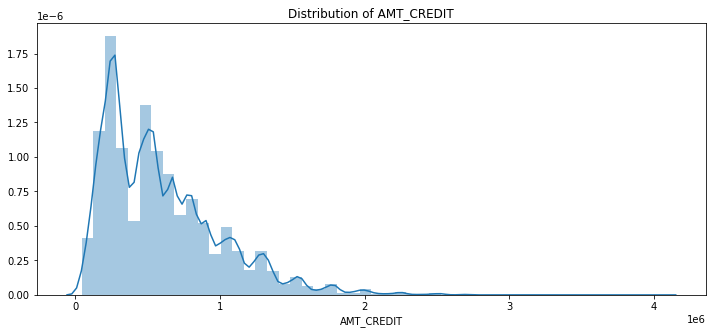

In [ ]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_CREDIT")
ax = sns.distplot(application_train["AMT_CREDIT"])

## Distribution of Total Income

In [ ]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_INCOME_TOTAL")
ax = sns.distplot(application_train["AMT_INCOME_TOTAL"].dropna())

## Types of Loan

In [ ]:
# plot_stats('NAME_CONTRACT_TYPE')
configure_plotly_browser_state()
temp = application_train["NAME_CONTRACT_TYPE"].value_counts()
fig = {
  "data": [
    {
      "values": temp.values,
      "labels": temp.index,
      "domain": {"x": [0, .48]},
      #"name": "Types of Loans",
      #"hoverinfo":"label+percent+name",
      "hole": .7,
      "type": "pie"
    },
    
    ],
  "layout": {
        "title":"Types of loan",
        "annotations": [
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Loan Types",
                "x": 0.17,
                "y": 0.5
            }
            
        ]
    }
}
iplot(fig, filename='donut')

## Gender

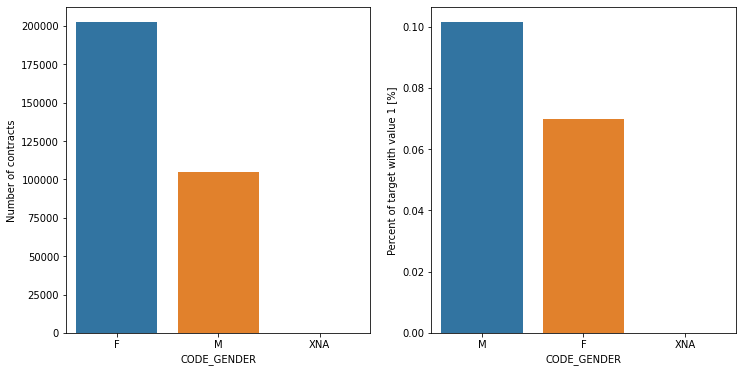

In [ ]:
plot_stats('CODE_GENDER')

The number of female clients is almost double the number of male clients. Looking to the percent of defaulted credits, males have a higher chance of not returning their loans (10%), comparing with women (~7%).

## Purpose of Loan

In [ ]:
configure_plotly_browser_state()
temp1 = application_train["FLAG_OWN_CAR"].value_counts()
temp2 = application_train["FLAG_OWN_REALTY"].value_counts()

fig = {
  "data": [
    {
      "values": temp1.values,
      "labels": temp1.index,
      "domain": {"x": [0, .48]},
      "name": "Own Car",
      "hoverinfo":"label+percent+name",
      "hole": .6,
      "type": "pie"
    },
    {
      "values": temp2.values,
      "labels": temp2.index,
      # "text":"Own Realty",
      "textposition":"inside",
      "domain": {"x": [.52, 1]},
      "name": "Own Reality",
      "hoverinfo":"label+percent+name",
      "hole": .6,
      "type": "pie"
    }],
  "layout": {
        "title":"Purpose of loan",
        "annotations": [
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Own Car",
                "x": 0.20,
                "y": 0.5
            },
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Own Realty",
                "x": 0.8,
                "y": 0.5
            }
        ]
    }
}
iplot(fig, filename='donut')


## Income sources of Applicant

In [ ]:
configure_plotly_browser_state()
temp = application_train["NAME_INCOME_TYPE"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
df.iplot(kind='pie',labels='labels',values='values', title='Income sources of Applicant\'s', hole = 0.5)

## Family Status of Applicant

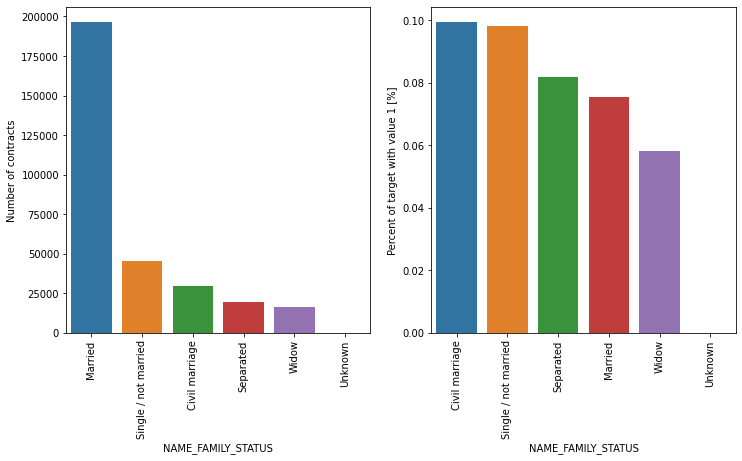

In [ ]:
plot_stats('NAME_FAMILY_STATUS',True, True)

## Children & Family members/


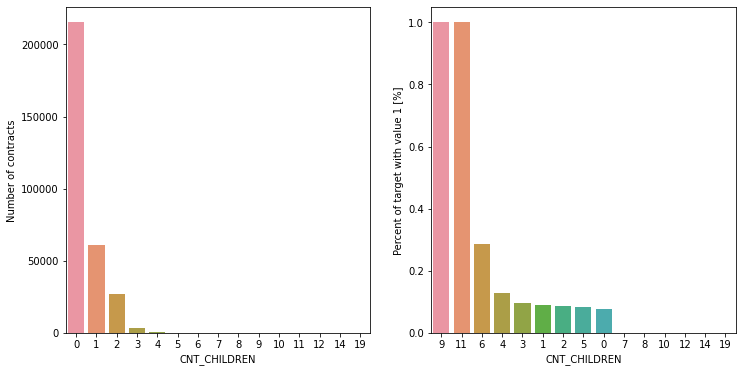

In [ ]:
plot_stats('CNT_CHILDREN')

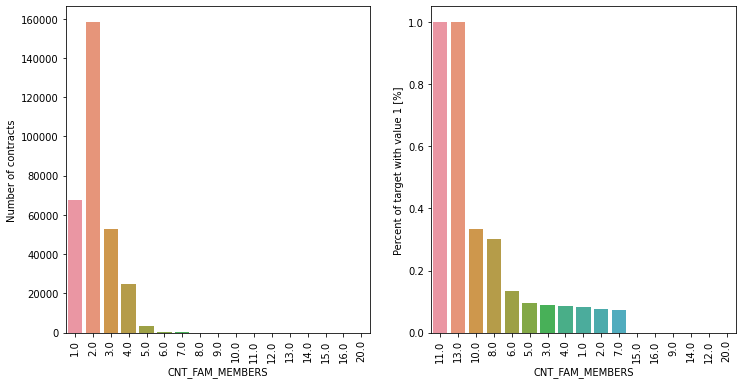

In [ ]:
plot_stats('CNT_FAM_MEMBERS',True)

## Occupation of Applicant

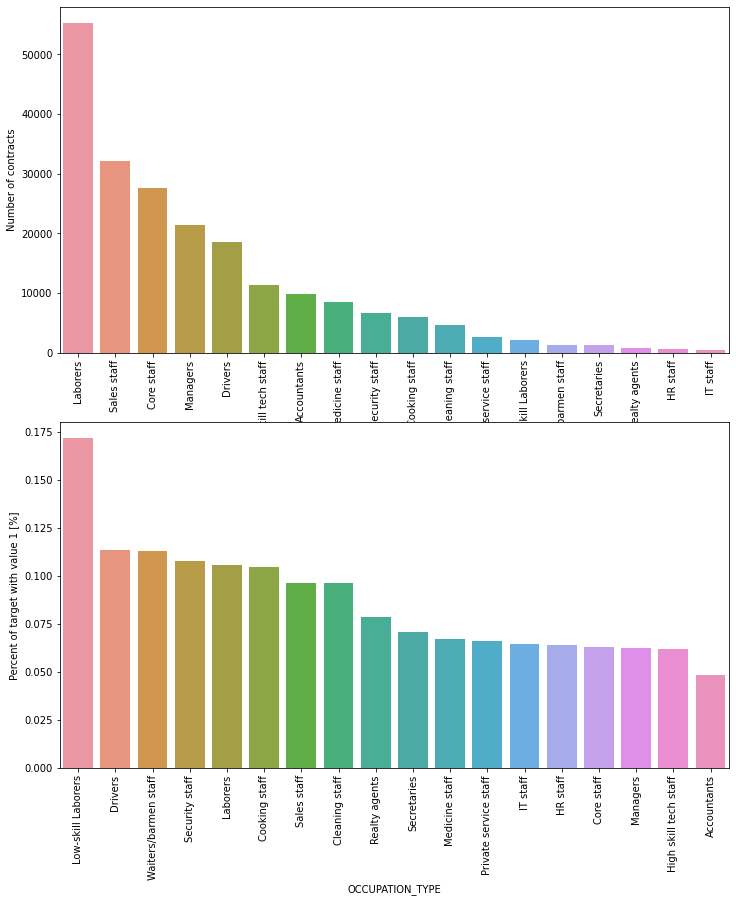

In [ ]:
plot_stats('OCCUPATION_TYPE',True, False)

## Income of applicant

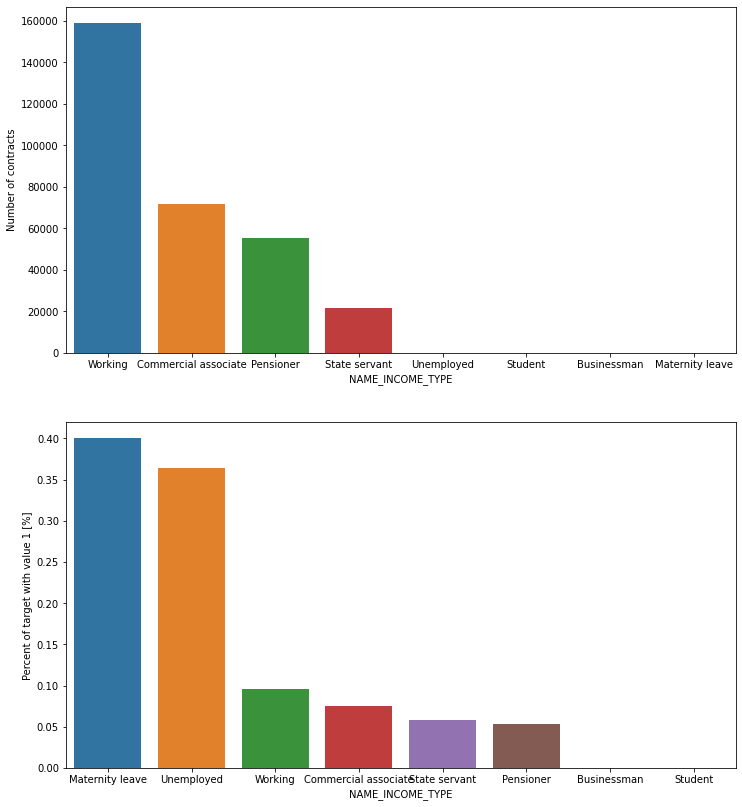

In [ ]:
plot_stats('NAME_INCOME_TYPE',False,False)

## Education of Applicant

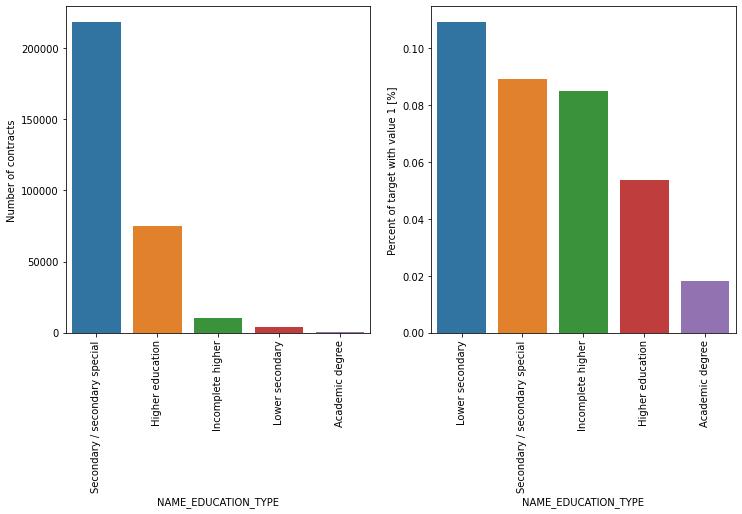

In [ ]:
plot_stats('NAME_EDUCATION_TYPE',True)

## Housing

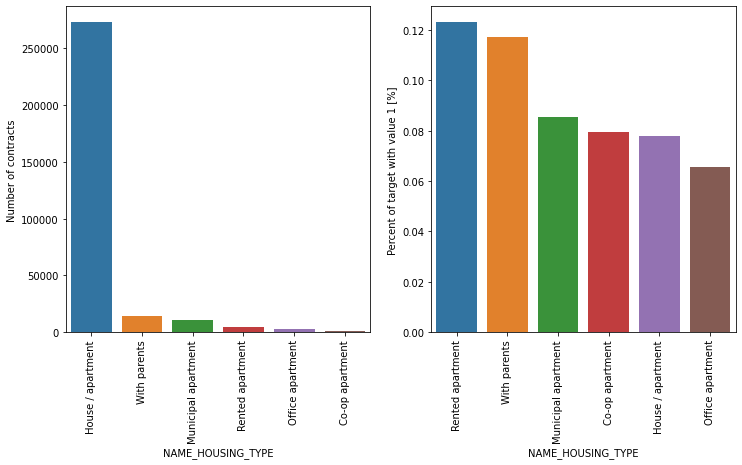

In [ ]:
plot_stats('NAME_HOUSING_TYPE',True)

## Types of Organizations who applied for loan

# Bureau Data

In [ ]:
application_bureau_train = application_train.merge(bureau, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

## Credit Status

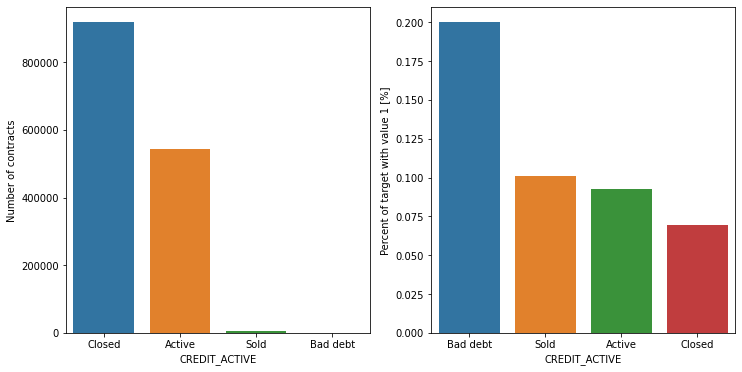

In [ ]:
plot_b_stats('CREDIT_ACTIVE')


## Credit Currency

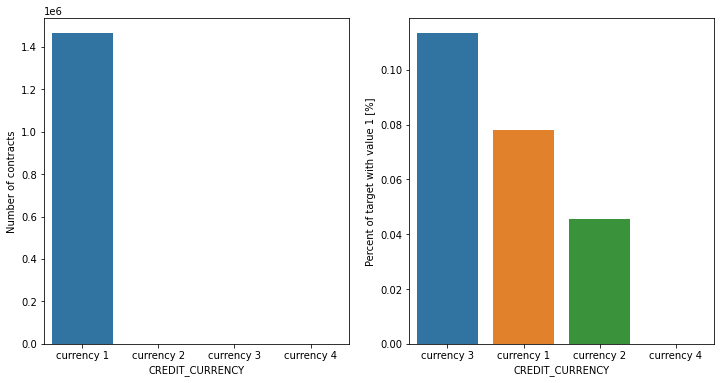

In [ ]:
plot_b_stats('CREDIT_CURRENCY')


## Credit Type

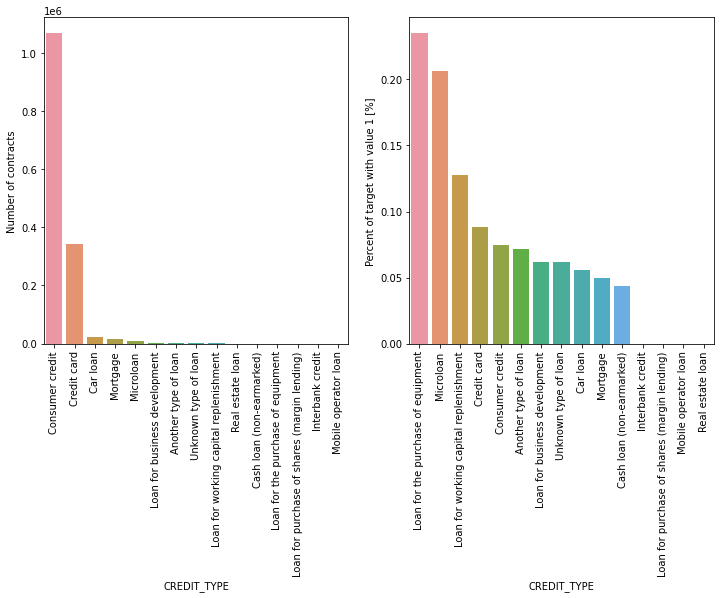

In [ ]:
plot_b_stats('CREDIT_TYPE', True, True)

## Duration of credit (DAYS_CREDIT)

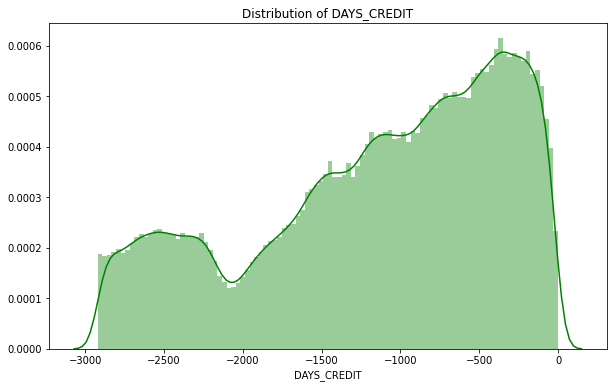

In [ ]:
def plot_b_distribution(feature,color):
    plt.figure(figsize=(10,6))
    plt.title("Distribution of %s" % feature)
    sns.distplot(application_bureau_train[feature].dropna(),color=color, kde=True,bins=100)
    plt.show() 
    
plot_b_distribution('DAYS_CREDIT','green')

# Previous application data

In [ ]:
application_prev_train = application_train.merge(previous_application, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

## Contract Type

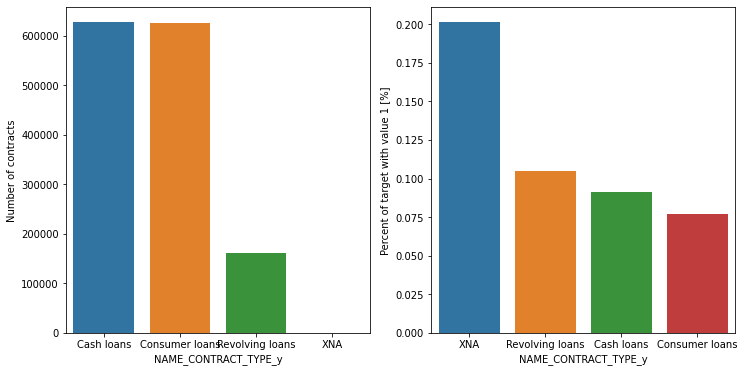

In [ ]:
plot_p_stats('NAME_CONTRACT_TYPE_y')

## Cash Loan Purpose

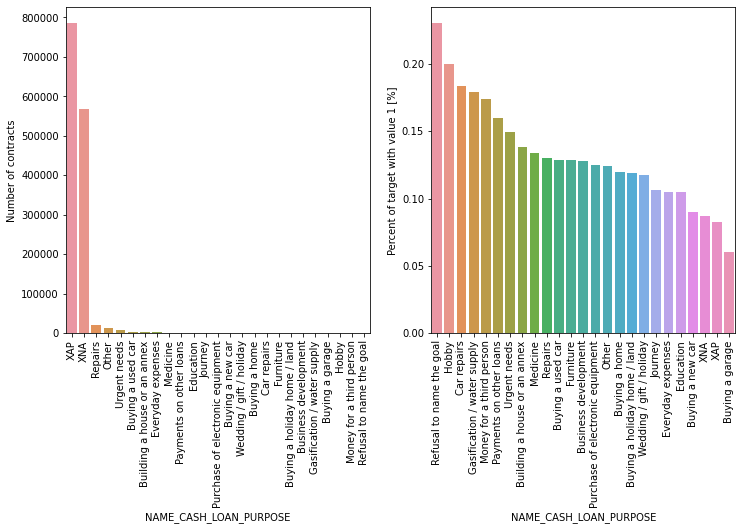

In [ ]:
plot_p_stats('NAME_CASH_LOAN_PURPOSE', True, True)

## Contract Status

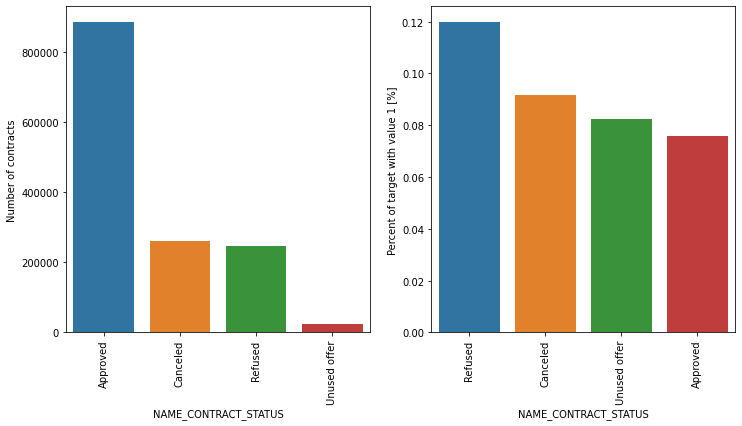

In [ ]:
plot_p_stats('NAME_CONTRACT_STATUS', True, True)

## Payment Type

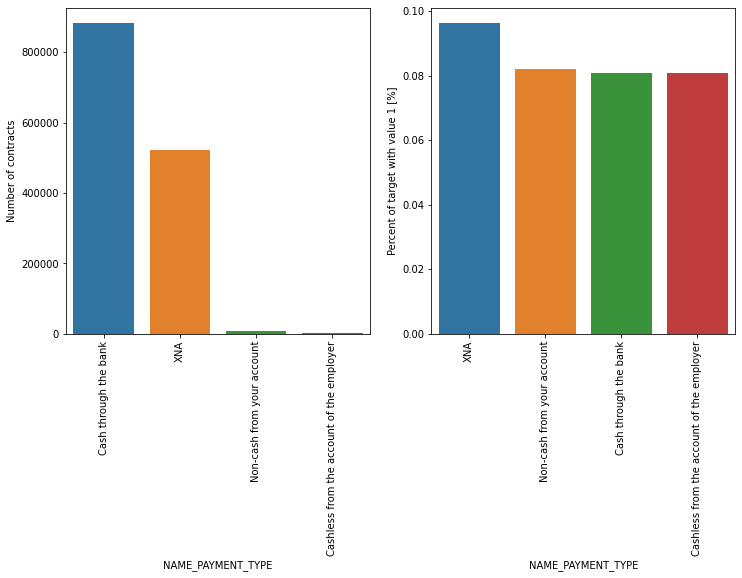

In [ ]:
plot_p_stats('NAME_PAYMENT_TYPE', True, True)

## Client Type

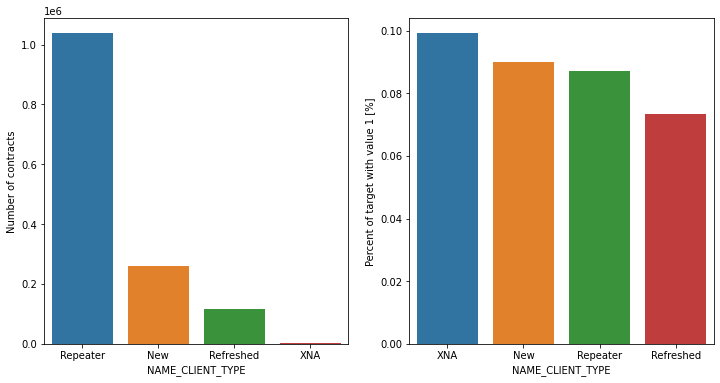

In [ ]:
plot_p_stats('NAME_CLIENT_TYPE')

In [ ]:
del application_train, previous_application, bureau, application_bureau_train, application_prev_train
import gc; gc.collect()

605

# Predictive Model development

## Import processed file

In [ ]:
df=pd.read_csv("/content/drive/My Drive/Colab Notebooks/HomeCredit/process1/final1.csv")
y=pd.read_csv("/content/drive/My Drive/Colab Notebooks/HomeCredit/process1/target.csv")
df.drop('SK_ID_CURR', axis=1, inplace=True)

time: 1min 11s


## Under sampling

In [ ]:

sampling_strategy = 0.7
rus = RandomUnderSampler(sampling_strategy=sampling_strategy)
X_res, y_res = rus.fit_resample(df, y)

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.


time: 5.42 s


## Split Train, Test and validation set

In [ ]:
from sklearn.model_selection import train_test_split
from collections import Counter
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.02, random_state=200)

X_train1, X_valid, y_train1, y_valid = train_test_split(X_train, y_train, test_size=.05, random_state=200)
print("Train shape: ",X_train1.shape)
print("Valid shape: ",X_valid.shape)
print("Test shape: ",X_test.shape)

print("Y count in Train: ", Counter(y_train1.ravel()))
print("Y count in valid: ", Counter(y_valid.ravel()))
print("Y count in Test: ", Counter(y_test.ravel()))

Train shape:  (56128, 1130)
Valid shape:  (2955, 1130)
Test shape:  (1206, 1130)
Y count in Train:  Counter({0: 33060, 1: 23068})
Y count in valid:  Counter({0: 1717, 1: 1238})
Y count in Test:  Counter({0: 687, 1: 519})
time: 895 ms


In [ ]:
def plot_cm(labels, predictions, p=0.5):
  # cm = confusion_matrix(labels, predictions > p)
  cm = confusion_matrix(labels, predictions)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

def plot_classification_report(label, predictions):
  print(classification_report(label, predictions))

def plot_roc(y_test, probas):
  a=1

def plot_roc_curve(clf, test, clf_name):
    x_test, y_test = test
    y_pred = []
    fpr = list()
    tpr = list()
    aucs = list()
    for i in range(len(clf)):
      # print(clf_name[i])
      if "Neural" in clf_name[i]:
        BATCH_SIZE=32
        y_pred = clf[i].predict(X_test, batch_size=BATCH_SIZE)
        # y_pred = [0 if x<0.5 else 1 for x in test_predictions_baseline]
      else:
       
        y_pred = clf[i].predict_proba(x_test)[:, 1]
      fpr, tpr, _ = roc_curve(y_test, y_pred)
      roc_auc = auc(fpr, tpr)

      lw = 2
      plt.plot(fpr, tpr, label='ROC curve for ' + clf_name[i] + ' (area = %0.2f)' % roc_auc)
      plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('Receiver operating characteristic')
      plt.legend(loc=0)
    plt.show()

time: 36.4 ms


In [ ]:
clfs = []
names = []

def do_lr(X_train, y_train):
  lr= LogisticRegression(C=.001, penalty='l2', solver='lbfgs', class_weight=None, max_iter=1000, l1_ratio=None, verbose=1)
  lr.fit(X_train, y_train.ravel())
  return lr, "Logistic Regression"


def do_rf(X_train, y_train):
  rf = RandomForestClassifier(n_estimators= 1200, min_samples_split= 10, min_samples_leaf= 2, max_features= 'auto', max_depth= None, bootstrap= False)
  rf.fit(X_train, y_train.ravel())
  return rf, "Random Forests"

def do_nb(X_train, y_train):
  nb = GaussianNB()
  nb.fit(X_train, y_train)
  return nb, "Naive Bayes"



time: 7.32 ms


## Model 1: Logistics regression

In [ ]:
clf, mName = do_lr(X_train, y_train)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


time: 18.1 s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.9s finished


### Model performance on unseen data

Legitimate Transactions Detected (True Negatives):  589
Legitimate Transactions Incorrectly Detected (False Positives):  138
Fraudulent Transactions Missed (False Negatives):  236
Fraudulent Transactions Detected (True Positives):  243
Total Fraudulent Transactions:  479
              precision    recall  f1-score   support

           0       0.71      0.81      0.76       727
           1       0.64      0.51      0.57       479

    accuracy                           0.69      1206
   macro avg       0.68      0.66      0.66      1206
weighted avg       0.68      0.69      0.68      1206



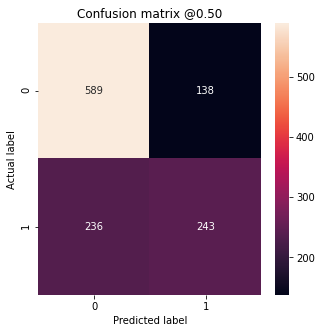

time: 478 ms


In [ ]:
plot_cm(y_test, clf.predict(X_test))
plot_classification_report(y_test, clf.predict(X_test))
clfs.append(clf)
names.append(mName)


### Model explainer

The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!


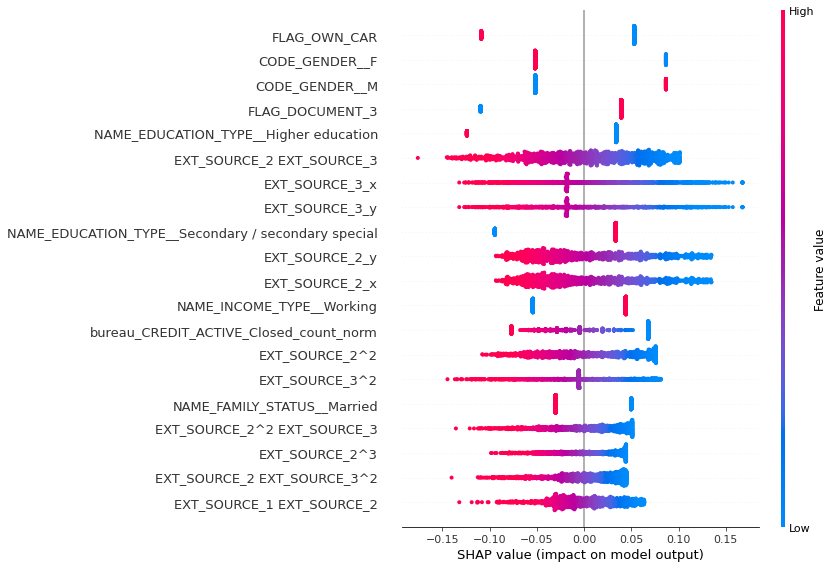

In [ ]:
explainer = shap.LinearExplainer(clf, X_train, feature_dependence="independent")
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names =df.columns)

In [ ]:
shap.initjs()
ind = 5
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test[ind,:],
    feature_names=df.columns
)


In [ ]:
shap.initjs()
ind = 2
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test[ind,:],
    feature_names=df.columns
)


### ROC Curve

Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.


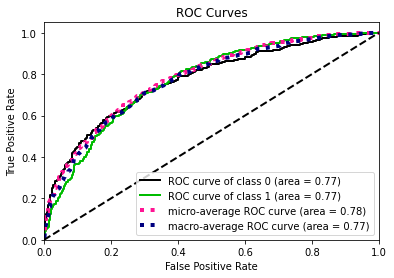

In [ ]:
skplt.metrics.plot_roc_curve(y_test, clf.predict_proba(X_test), )

## Model 2: Random Forest

In [ ]:
clf, mName = do_rf(X_train, y_train)

time: 26min 43s


### Model performance on unseen data

Legitimate Transactions Detected (True Negatives):  589
Legitimate Transactions Incorrectly Detected (False Positives):  138
Fraudulent Transactions Missed (False Negatives):  230
Fraudulent Transactions Detected (True Positives):  249
Total Fraudulent Transactions:  479
              precision    recall  f1-score   support

           0       0.72      0.81      0.76       727
           1       0.64      0.52      0.58       479

    accuracy                           0.69      1206
   macro avg       0.68      0.67      0.67      1206
weighted avg       0.69      0.69      0.69      1206



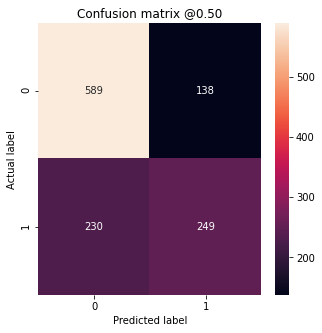

time: 2.69 s


In [ ]:
plot_cm(y_test, clf.predict(X_test))
plot_classification_report(y_test, clf.predict(X_test))
clfs.append(clf)
names.append(mName)

### Model explainer

feature_dependence = "independent" has been renamed to feature_perturbation = "interventional"! See GitHub issue #882.
100%|===================| 2411/2412 [135:32<00:03]       

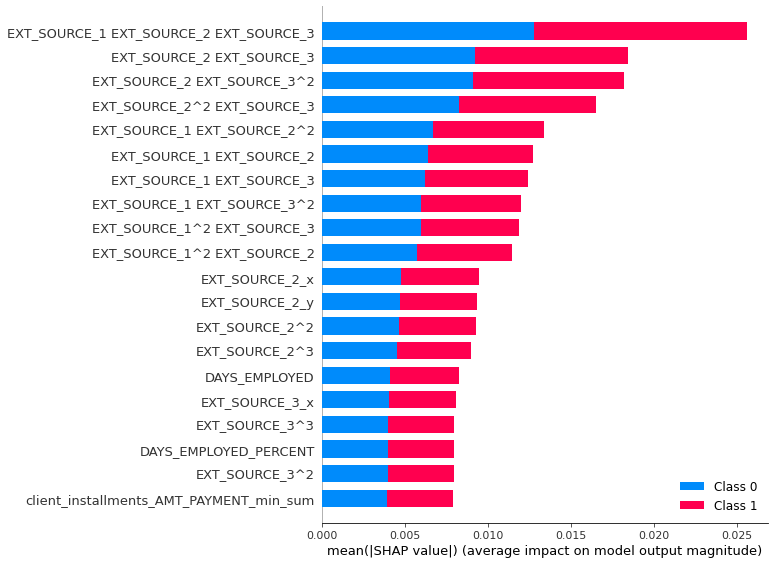

time: 2h 15min 43s


In [ ]:
# explainer = shap.TreeExplainer(clf, X_train, feature_dependence="independent")
# explainer = shap.TreeExplainer(clf, data = shap.sample(X_train, 100), feature_dependence="independent")
explainer = shap.KernelExplainer(clf.predict_proba, X_train)
# shap_values = explainer.shap_values(X_test)
shap_values = explainer.shap_values(X_test[100,:])
shap.summary_plot(shap_values, X_test, feature_names =df.columns)

In [ ]:

# import pickle
# with open("/content/drive/My Drive/Colab Notebooks/HomeCredit/process1/shapvalrf.txt", 'wb') as fp:
#     pickle.dump(shap_values, fp)

# explainer = shap.KernelExplainer(clf.predict_proba, X_train)
# # shap_values = explainer.shap_values(X_test)
# shap_values = explainer.shap_values(X_test[100,:])
# shap.summary_plot(shap_values, X_test, feature_names =df.columns)

Using 59083 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [ ]:
shap.initjs()
ind = 5
shap.force_plot(
    explainer.expected_value[1], shap_values[1],
    feature_names=df.columns
)


array([ 1.14375199e-04, -3.35808187e-04,  1.89710002e-06, ...,
       -9.21403652e-05,  1.23267971e-04,  1.08376796e-04])

time: 10.8 ms


### ROC Curve

## Model 3: LightGBM

In [ ]:
def learning_rate_010_decay_power_099(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_005_decay_power_099(current_iter):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

time: 5.45 ms


In [ ]:
def do_lgb(X_train, y_train, X_valid, y_valid):
  fit_params={"early_stopping_rounds":30, 
              "eval_metric" : 'auc', 
              "eval_set" : [(X_valid,y_valid)],
              'eval_names': ['valid'],
              #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
              'verbose': 100,
              'categorical_feature': 'auto'}

  opt_parameters = {'colsample_bytree': 0.9404729076071855, 'min_child_samples': 361, 'min_child_weight': 0.01, 'num_leaves': 13, 'reg_alpha': 50, 'reg_lambda': 5, 'subsample': 0.8840871468588312}

  random_search_cv = {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 5000, 'n_jobs': 4, 'num_leaves': 31, 'objective': None, 'random_state': 314, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'metric': 'None'}

  # clf_final = lgb.LGBMClassifier(**clf_lgb.get_params())
  clf_final = lgb.LGBMClassifier(**random_search_cv)
  clf_final.set_params(**opt_parameters)
  clf_final.fit(X_train, y_train.ravel(), **fit_params, callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)])

  return clf_final, "LightGBM Classifier"


time: 8.41 ms


In [ ]:
clf, mName = do_lgb(X_train1, y_train1, X_valid, y_valid)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.763858
[200]	valid's auc: 0.768727
[300]	valid's auc: 0.770239
[400]	valid's auc: 0.770997
[500]	valid's auc: 0.771465
[600]	valid's auc: 0.771737
[700]	valid's auc: 0.771903
[800]	valid's auc: 0.771994
[900]	valid's auc: 0.772058
Early stopping, best iteration is:
[908]	valid's auc: 0.772065
time: 2min 23s


### Model performace on unseen data

Legitimate Transactions Detected (True Negatives):  551
Legitimate Transactions Incorrectly Detected (False Positives):  136
Fraudulent Transactions Missed (False Negatives):  215
Fraudulent Transactions Detected (True Positives):  304
Total Fraudulent Transactions:  519
              precision    recall  f1-score   support

           0       0.72      0.80      0.76       687
           1       0.69      0.59      0.63       519

    accuracy                           0.71      1206
   macro avg       0.71      0.69      0.70      1206
weighted avg       0.71      0.71      0.70      1206



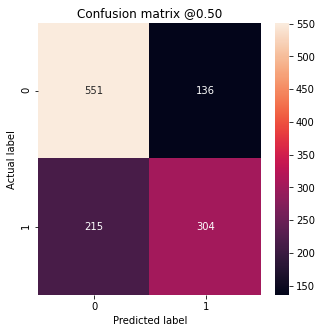

time: 523 ms


In [ ]:
plot_cm(y_test, clf.predict(X_test))
plot_classification_report(y_test, clf.predict(X_test))
clfs.append(clf)
names.append(mName)


### Model Explainer

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


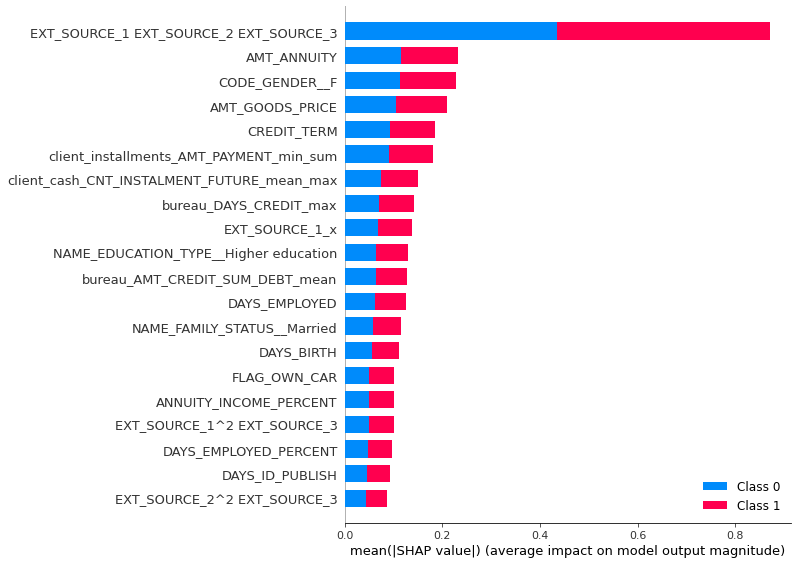

time: 1.33 s


In [ ]:

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train1[:100,:])
shap.summary_plot(shap_values, X_train1[:100,:], feature_names =df.columns)

In [ ]:
shap.initjs()
index=11
print('Model prediction:', clf.predict_proba(X_train1[index].reshape(1,-1))[:,1])
shap.force_plot(explainer.expected_value[0], shap_values[0][index,:], X_test[index,:], feature_names=df.columns)

Model prediction: [0.73112888]


time: 131 ms


In [ ]:
shap.initjs()
index=9
print('Model prediction:', clf.predict_proba(X_train1[index].reshape(1,-1))[:,1])
shap.force_plot(explainer.expected_value[0], shap_values[0][index,:], X_test[index,:], feature_names=df.columns)

Model prediction: [0.17165121]


time: 30.5 ms


### ROC Curve

Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.


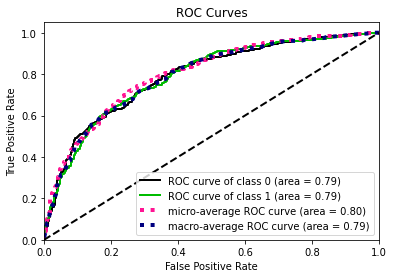

time: 316 ms


In [ ]:
skplt.metrics.plot_roc_curve(y_test, clf.predict_proba(X_test), )

time: 962 µs


## Model 4: Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from tensorflow.keras import backend

from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC
import tensorflow.keras.metrics
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.layers import Dropout
import keras

time: 72.7 ms


In [ ]:
def nn_arch():
  METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
  ]
  classifier = Sequential()
#First Hidden Layer
  classifier.add(Dense(16, activation='elu', input_dim=X_train1.shape[-1]))
  #Second  Hidden Layer
  # classifier.add(Dropout(0.2))
  classifier.add(Dense(16, activation='elu'))
  classifier.add(Dropout(0.5))

  classifier.add(Dense(16, activation='elu'))
  classifier.add(Dropout(0.5))
  #Output Layer
  classifier.add(Dense(1, activation='sigmoid'))
  classifier.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=METRICS)

  classifier.summary()
  return classifier

def do_nn(X_train, y_train, X_valid, y_valid):
  classifier = nn_arch()
  BATCH_SIZE = 32
  EPOCHS =150
  history = classifier.fit(X_train1, y_train1, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_valid, y_valid), verbose=1)
  return classifier, "Neural Network"



time: 19 ms


In [ ]:
clf, mName = do_nn(X_train, y_train, X_valid, y_valid)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                18080     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 18,641
Trainable params: 18,641
Non-trainable params: 0
____________________________________________________

### Model performance on unseen data


Legitimate Transactions Detected (True Negatives):  572
Legitimate Transactions Incorrectly Detected (False Positives):  155
Fraudulent Transactions Missed (False Negatives):  227
Fraudulent Transactions Detected (True Positives):  252
Total Fraudulent Transactions:  479
              precision    recall  f1-score   support

           0       0.72      0.79      0.75       727
           1       0.62      0.53      0.57       479

    accuracy                           0.68      1206
   macro avg       0.67      0.66      0.66      1206
weighted avg       0.68      0.68      0.68      1206



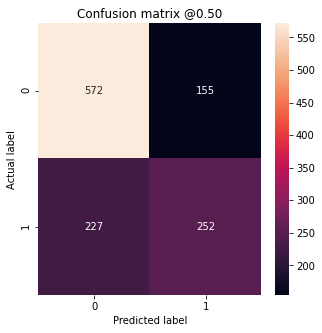

time: 449 ms


In [ ]:
BATCH_SIZE=32
test_predictions_baseline = clf.predict(X_test, batch_size=BATCH_SIZE)
y_pred = [0 if x<0.5 else 1 for x in test_predictions_baseline]


plot_cm(y_test, y_pred)
print(classification_report(y_test, y_pred))
clfs.append(clf)
names.append(mName)

### Model Explainer

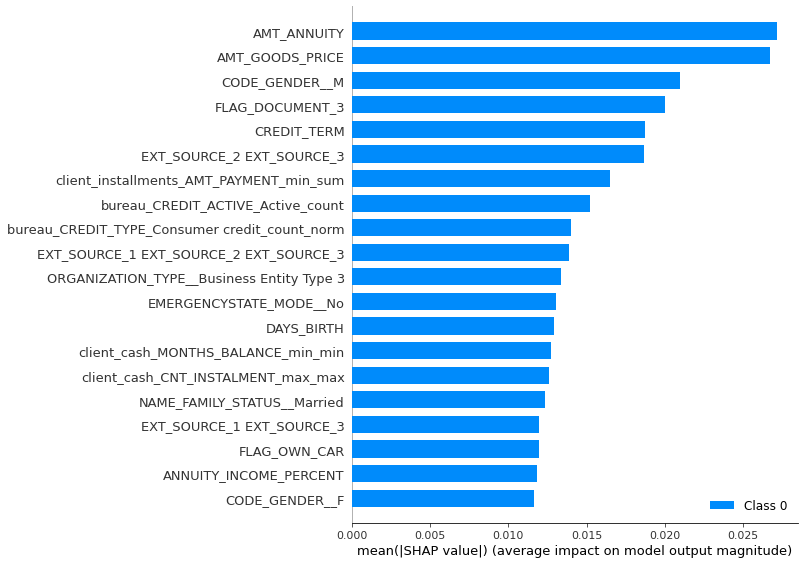

time: 1.62 s


In [ ]:
background = X_train1[:200,:]
explainer = shap.DeepExplainer(clf, background)
shap_values = explainer.shap_values(X_test[:200,])
shap.summary_plot(shap_values, X_test[:200,], feature_names =df.columns)

# Model Comparision

### ROC AUC curve

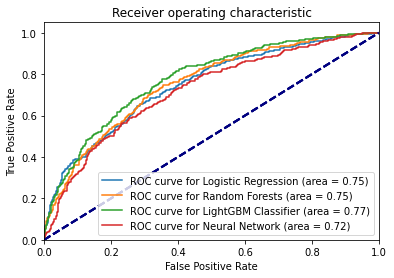

time: 2.04 s


In [ ]:
plot_roc_curve(clfs, [X_test, y_test], names)

In [ ]:
def get_nn_proba(clf, X_test):
  one_prob = clf.predict(X_test, batch_size=32)
  zero_prob = 1-one_prob
  proba = np.hstack([zero_prob, one_prob])
  return proba

lr_probs = clfs[0].predict_proba(X_test)
rf_probs = clfs[1].predict_proba(X_test)
lgb_probs = clfs[2].predict_proba(X_test)
nn_probs = get_nn_proba(clfs[3], X_test)

time: 2.59 ms


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
threshold = []
opp_loss = []
real_loss = []
total_loss = []
loan_val = 100000
loss_def = 0.7
gain_no_def = 0.2

for x in np.linspace(0,1,1000):
  model = clfs[1]
  predictions = model.predict_proba(X_test)[:,1]>x
  cm = confusion_matrix(y_test, predictions)
  pcm = cm/np.sum(cm)
  opp=pcm[0, 1]*loan_val*gain_no_def
  real = pcm[1, 0]*loan_val*loss_def
  total = opp+real

  threshold.append(x)
  opp_loss.append(opp)
  real_loss.append(real)
  total_loss.append(total)

min_loss = round(min(total_loss),3)
imin = total_loss.index(min(total_loss))
min_loss_threshold = round(threshold[imin],3)


fig = plt.figure()
plt.plot(threshold, total_loss)
plt.plot([min_loss_threshold, min_loss_threshold], [0,max(total_loss)])





### Calibration/ Reliability Curve

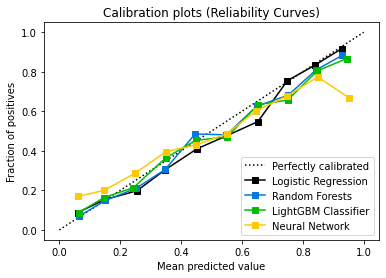

time: 288 ms


In [ ]:
skplt.metrics.plot_calibration_curve(y_test.ravel(), [lr_probs, rf_probs, lgb_probs, nn_probs],names)

# Unsupervised Model

In [ ]:
from sklearn.decomposition import PCA 
pca = PCA(80)  
projected = pca.fit_transform(df)
print(df.shape)
print(projected.shape)
# np.cumsum(pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

(307511, 1129)
(307511, 80)
time: 1min


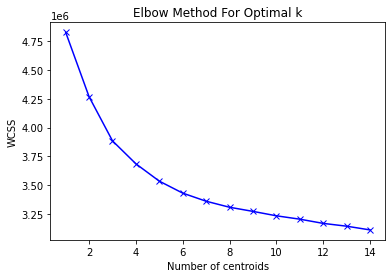

time: 8min 35s


In [ ]:
from sklearn.cluster import KMeans
wcss = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(projected)
    wcss.append(km.inertia_)
plt.plot(K, wcss, 'bx-')
plt.xlabel('Number of centroids')
plt.ylabel('WCSS')
plt.title('Elbow Method For Optimal k')
plt.show()


In [ ]:
km = KMeans(n_clusters=3).fit(projected)
y_kmeans = km.predict(projected)
aa =pd.DataFrame(data={'truth':y.values.ravel(),'ymeans':y_kmeans}, )

time: 19.5 s


In [ ]:
aa.groupby('ymeans').sum()

,truth
ymeans,
0,10890
1,12366
2,1569


time: 34.2 ms


In [ ]:
aa.groupby('ymeans').count()

,truth
ymeans,
0,156009
1,127000
2,24502


time: 24.5 ms


In [ ]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=3, min_samples=50).fit(projected)